# NOTEBOOK UNICAMENTE PARA LA PRESENTACION

Este notebook no esta bien docuentado ni explicado. Unicamente me imprime los resultados que necesitaba para la presentacion del proyecto.


In [1]:
import pandas as pd
from scipy.stats import poisson
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
pd.options.display.max_columns = None #quitar limite de visualizacion de columnas
import matplotlib.pyplot as plt
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
import math

### NOS BASAMOS EN LAS ULTIMAS 4 TEMPORADAS 18/19, 19/20, 20/21, 21/22 PARA TRATAR DE PREDECIR LA TEMPORADA 22/23 

In [2]:
resultados = pd.read_csv('resultados_93_23_la_liga.csv')
resultados_previos = resultados[((resultados.Temporada == '20/21') | (resultados.Temporada == '19/20') | (resultados.Temporada == '18/19') | (resultados.Temporada == '21/22'))]

In [3]:
resultados_previos.head()

,Temporada,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
70,21/22,La Liga,2022-05-22,Sevilla,Ath Bilbao,1,0,H
71,21/22,La Liga,2022-05-22,Barcelona,Villarreal,0,2,A
72,21/22,La Liga,2022-05-22,Osasuna,Mallorca,0,2,A
73,21/22,La Liga,2022-05-22,Granada,Espanol,0,0,D
74,21/22,La Liga,2022-05-22,Alaves,Cadiz,0,1,A


In [5]:
print(len(resultados_previos),'partidos disputados')

1520 partidos disputados


# ANALIZAMOS POR ENCIMA LOS DATOS

In [6]:
resultados_previos.FTR.value_counts(normalize=True)

H    0.437500
D    0.286184
A    0.276316
Name: FTR, dtype: float64

Podemos ver como jugar de local es un factor determinante puesto que el en el 44% de los encuentros ha ganado el equipo local

In [7]:
resultados_previos.mean()

FTHG    1.419737
FTAG    1.099342
dtype: float64

Efectivamente vemos como el promedio de goles anotados en casa es notablemente superior a los anotados fuea de casa

In [8]:
resultados_previos.FTHG.value_counts(normalize=True)

1    0.344737
2    0.257895
0    0.238816
3    0.097368
4    0.043421
5    0.014474
6    0.002632
8    0.000658
Name: FTHG, dtype: float64

La distribucion de Poisson describe la probabilidad de que suceda un suceso en un intervalo de tiempo determinado (90 minutos) a traves de una cota promedia de ocurrencia. (el numero de eventos es independiente del tiempo)

In [9]:
poisson_pred = np.column_stack([[poisson.pmf(i, resultados_previos.mean()[j]) for i in range(8)] for j in range(2)])
poisson_pred

array([[2.41777634e-01, 3.33090150e-01],
       [3.43260615e-01, 3.66180027e-01],
       [2.43669871e-01, 2.01278561e-01],
       [1.15315698e-01, 7.37579989e-02],
       [4.09294861e-02, 2.02713184e-02],
       [1.16218199e-02, 4.45702278e-03],
       [2.74998764e-03, 8.16632134e-04],
       [5.57751252e-04, 1.28251156e-04]])

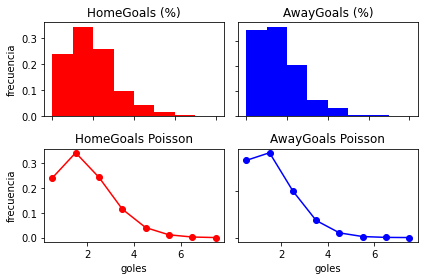

In [10]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(resultados_previos[['FTHG']].values, range(9), 
        label=['Home'], density=True, color=['red'])
axs[0 ,0].set_title('HomeGoals (%)')
axs[0, 1].hist(resultados_previos[['FTAG']].values, range(9), 
        label=['Home'], density=True, color=['blue'])
axs[0 ,1].set_title('AwayGoals (%)')
axs[1, 0].plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'red')
axs[1 ,0].set_title('HomeGoals Poisson')
axs[1, 1].plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Home", color = 'blue')
axs[1 ,1].set_title('AwayGoals Poisson')

for ax in axs.flat:
    ax.set(xlabel='goles', ylabel='frecuencia')
    ax.label_outer()
    
plt.tight_layout()
plt.show()

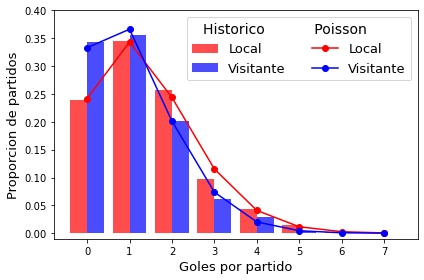

In [11]:
# plot histogram of actual goals
plt.hist(resultados_previos[['FTHG', 'FTAG']].values, range(9), 
         alpha=0.7, label=['Local', 'Visitante'], density=True, color=['red', 'blue'])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Local", color = 'red')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Visitante", color = 'blue')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("  Historico           Poisson        ", prop = {'size':'14'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goles por partido",size=13)
plt.ylabel("Proporcion de partidos",size=13)
plt.ylim([-0.01, 0.4])
plt.tight_layout()
plt.show()

EFECTIVAMENTE PODEMOS VER COMO LA CANTIDAD DE GOLES SIGUE UNA DISTRIBUCION DE POISSON

# EMPECEMOS A DEFINIR PARAMETROS

In [12]:
def historico_1_equipo(team, resultados):
    historico = resultados[(resultados.HomeTeam == team) | 
          (resultados.AwayTeam == team)]

    team_local = historico[historico.HomeTeam==team]
    team_visit = historico[historico.AwayTeam==team]
    df = pd.DataFrame()
    df['Equipo'] = [team]
    df['VL'] = [list(team_local.FTR.values).count('H')]
    df['DL'] = [list(team_local.FTR.values).count('A')]
    df['EL'] = [list(team_local.FTR.values).count('D')]
    df['GML'] = [sum(team_local.FTHG)]
    df['GEL'] = [sum(team_local.FTAG)]
    df['VV'] = [list(team_visit.FTR.values).count('A')]
    df['DV'] = [list(team_visit.FTR.values).count('H')]
    df['EV'] = [list(team_visit.FTR.values).count('D')]
    df['GMV'] = [team_visit.FTAG.count()]
    df['GEV'] = [team_visit.FTHG.count()]
    
    return historico, df, team_local, team_visit

# FUERZA DE ATAQUE
Calculada para equipo tanto en campo local como visitante.

$$FAL=\frac{promedio\,goles\,del\,equipo\,local\,de\,local}{promedio\,total\,goles\,locales\,de\,locales} - 1$$

$$FAV=\frac{promedio\,goles\,equipo\,del\,visitante\,de\,visitante}{promedio\,total\,goles\,visitantes\,de\,visitantes} - 1$$

In [13]:
def fuerza_ataque(equipo, resultados):
    team_local = historico_1_equipo(equipo, resultados_previos)[2]
    team_visit = historico_1_equipo(equipo, resultados_previos)[3]
    promedio_goles_de_local = team_local.FTHG.mean()
    promedio_goles_total_locales = resultados.FTHG.mean()
    promedio_goles_de_visitante = team_visit.FTAG.mean()
    promedio_goles_total_visitantes = resultados.FTAG.mean()
    FAL = promedio_goles_de_local / promedio_goles_total_locales - 1
    FAV = promedio_goles_de_visitante / promedio_goles_total_visitantes - 1
    return FAL, FAV

### Veamos un ejemplo 

In [14]:
local = 'Osasuna'
visitante = 'Valencia'

In [15]:
historico, df, team_local, team_visit = historico_1_equipo(local, resultados_previos)
df

,Equipo,VL,DL,EL,GML,GEL,VV,DV,EV,GMV,GEV
0,Osasuna,19,19,19,64,78,17,24,16,57,57


In [16]:
historico, df, team_local, team_visit = historico_1_equipo(visitante, resultados_previos)
df

,Equipo,VL,DL,EL,GML,GEL,VV,DV,EV,GMV,GEV
0,Valencia,32,12,32,113,75,18,35,23,76,76


In [17]:
FAL_A, FAV_A = fuerza_ataque(local, resultados_previos)
FAL_B, FAV_B = fuerza_ataque(visitante, resultados_previos)
print('Fuerza de ataque del',local ,':', FAL_A, 'como local')
print('El',local ,'anotó un', round((FAL_A)*100,2), '% mas de goles en casa que el equipo promedio teorico')
print('\n')
print('Fuerza de ataque del',visitante ,':', FAV_B, 'como visitante')
print('El',visitante ,'anotó un', round((FAV_B)*100,2), '% mas de goles de visitante que el equipo promedio teorico')

Fuerza de ataque del Osasuna : -0.20914426938523334 como local
El Osasuna anotó un -20.91 % mas de goles en casa que el equipo promedio teorico


Fuerza de ataque del Valencia : -0.018551765409934085 como visitante
El Valencia anotó un -1.86 % mas de goles de visitante que el equipo promedio teorico


# FUERZA DEFENSIVA
Calculada para equipo tanto en campo local como visitante.

$$FDL=\frac{promedio\,goles\,encajados\,al\,equipo\,local\,de\,local}{promedio\,total\,goles\,encajados\,a\,los\,locales} - 1$$

$$FDV=\frac{promedio\,goles\,encajados\,equipo\,al\,visitante\,de\,visitante}{promedio\,total\,goles\,encajados\,a\,los\,visitantes} - 1$$

In [18]:
def fuerza_defensa(equipo, resultados):
    team_local = historico_1_equipo(equipo, resultados_previos)[2]
    team_visit = historico_1_equipo(equipo, resultados_previos)[3]
    promedio_encajados_de_local = team_local.FTAG.mean()
    promedio_encajados_total_locales = resultados.FTAG.mean()
    promedio_encajados_de_visitante = team_visit.FTHG.mean()
    promedio_encajados_total_visitantes = resultados.FTHG.mean()
    FDL = promedio_encajados_de_local / promedio_encajados_total_locales - 1
    FDV = promedio_encajados_de_visitante / promedio_encajados_total_visitantes -1
    return FDL, FDV

### Veamos un ejemplo 

In [19]:
FDL_A, FDV_A = fuerza_defensa(local, resultados_previos)
FDL_B, FDV_B = fuerza_defensa(visitante, resultados_previos)
print('Fuerza de defensa del',visitante, ':', FDV_B, 'como visitante')
print('El', visitante,'condecio un', round((FDV_B)*100,2), '% mas de goles fuera de casa que el equipo promedio teorico')
print('\n')
print('Fuerza de defensa del',local, ':', FDL_A, 'como local')
print('El', local,'condecio un', round((FDL_A)*100,2), '% mas de goles en casa que el equipo promedio teorico')

Fuerza de defensa del Valencia : 0.10287303058387409 como visitante
El Valencia condecio un 10.29 % mas de goles fuera de casa que el equipo promedio teorico


Fuerza de defensa del Osasuna : 0.24476361460203488 como local
El Osasuna condecio un 24.48 % mas de goles en casa que el equipo promedio teorico


# DEFINIMOS FAL, FAV, FDL, FDV PARA CADA EQUIPO

In [20]:
def stats_1_equipo(team, resultados):
    historico, df, team_local, team_visit = historico_1_equipo(team, resultados)
    
    FAL, FAV = fuerza_ataque(team, resultados)
    FDL, FDV = fuerza_defensa(team, resultados)
    
    df['FAL'] = [FAL]
    df['FDL'] = [FDL]
    df['FAV'] = [FAV]
    df['FDV'] = [FDV]
     
    return df

In [21]:
stats_1_equipo(visitante, resultados_previos)

,Equipo,VL,DL,EL,GML,GEL,VV,DV,EV,GMV,GEV,FAL,FDL,FAV,FDV
0,Valencia,32,12,32,113,75,18,35,23,76,76,0.047266,-0.102334,-0.018552,0.102873


In [25]:
def stats_equipos(resultados):
    stats = pd.DataFrame(columns = stats_1_equipo('', resultados).columns)
    for team in resultados.HomeTeam.unique():
        stats = pd.concat([stats_1_equipo(team, resultados), stats])
    stats.reset_index(drop=True, inplace=True)
    return stats
stats_equipos(resultados_previos)

,Equipo,VL,DL,EL,GML,GEL,VV,DV,EV,GMV,GEV,FAL,FDL,FAV,FDV
0,Girona,3,10,6,17,28,6,9,4,19,19,-0.369787,0.340515,-0.04249,-0.073216
1,Leganes,12,13,13,36,42,7,20,11,38,38,-0.332715,0.005386,-0.257929,-0.036145
2,Valladolid,13,22,22,53,71,11,26,20,57,57,-0.345073,0.133054,-0.281867,-0.01143
3,Eibar,19,22,16,68,67,9,29,19,57,57,-0.159716,0.06922,-0.265909,0.124498
4,Huesca,10,15,13,41,51,4,22,12,38,38,-0.240037,0.220826,-0.138241,0.241891
5,Espanol,22,20,15,68,72,7,32,18,57,57,-0.159716,0.149013,-0.24995,0.099784
6,Villarreal,32,19,25,134,92,27,30,19,76,76,0.241891,0.101137,0.208857,-0.165894
7,Mallorca,15,14,9,45,47,4,28,6,38,38,-0.165894,0.125075,-0.257929,0.50139
8,Celta,29,27,20,109,98,14,34,28,76,76,0.010195,0.17295,-0.054458,0.047266
9,Levante,25,23,28,116,113,17,44,15,76,76,0.07507,0.352484,0.041293,0.28823


# EMPEZAMOS LA PREDICCION CON EL MODELO INICIAL

### Distribución de Poisson (ley de sucesos raros)

https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Poisson


$$X \sim Poisson(\lambda)$$

$$P(X=k)=\frac{\lambda ^{k}e^{-\lambda }}{k!}$$

para $k = 0, 1, 2,..$

La distribución de Poisson es una distribución de probabilidad discreta que expresa, a partir de una frecuencia de ocurrencia media, la probabilidad de que ocurra un determinado número de eventos durante cierto período de tiempo. Concretamente, se especializa en la probabilidad de ocurrencia de sucesos con probabilidades muy pequeñas, o sucesos raros. 

### Empecemos con un ejemplo 

In [26]:
# PROYECCION OBJETIVOS ESPERADOS EQUIPO LOCAL
objetivo_esperadoA = math.exp(FAL_A + FDV_B)
print('Se espera que el', local, 'marque', round(objetivo_esperadoA,3), 'goles contra el', visitante)
objetivo_esperadoB = math.exp(FAV_B + FDL_A)
print('Se espera que el', visitante, 'marque', round(objetivo_esperadoB,3), 'goles contra el', local)

Se espera que el Osasuna marque 0.899 goles contra el Valencia
Se espera que el Valencia marque 1.254 goles contra el Osasuna


In [27]:
#TABLA DE PROBABILIDADES DE CADA RESULTADO
teamA_poisson = [poisson.pmf(i, objetivo_esperadoA) for i in range(10)]
teamB_poisson = [poisson.pmf(i, objetivo_esperadoB) for i in range(10)]
partido = np.outer(teamA_poisson, teamB_poisson)
tabla = pd.DataFrame(partido)
tabla

,0,1,2,3,4,5,6,7,8,9
0,1.161327e-01,1.456119e-01,9.128713e-02,3.815319e-02,1.195951e-02,2.999066e-03,6.267254e-04,1.122592e-04,1.759440e-05,2.451176e-06
1,1.044243e-01,1.309315e-01,8.208363e-02,3.430661e-02,1.075376e-02,2.696702e-03,5.635394e-04,1.009413e-04,1.582054e-05,2.204050e-06
2,4.694814e-02,5.886552e-02,3.690401e-02,1.542392e-02,4.834788e-03,1.212411e-03,2.533619e-04,4.538222e-05,7.112763e-06,9.909196e-07
3,1.407162e-02,1.764358e-02,1.106112e-02,4.622965e-03,1.449116e-03,3.633923e-04,7.593937e-05,1.360227e-05,2.131887e-06,2.970053e-07
4,3.163233e-03,3.966192e-03,2.486487e-03,1.039220e-03,3.257543e-04,8.168883e-05,1.707080e-05,3.057726e-06,4.792378e-07,6.676535e-08
5,5.688636e-04,7.132646e-04,4.471603e-04,1.868893e-04,5.858239e-05,1.469060e-05,3.069948e-06,5.498896e-07,8.618428e-08,1.200682e-08
6,8.525186e-05,1.068923e-04,6.701299e-05,2.800788e-05,8.779360e-06,2.201585e-06,4.600730e-07,8.240835e-08,1.291587e-08,1.799384e-09
7,1.095098e-05,1.373078e-05,8.608112e-06,3.597735e-06,1.127747e-06,2.828032e-07,5.909839e-08,1.058571e-08,1.659101e-09,2.311388e-10
8,1.230863e-06,1.543307e-06,9.675311e-07,4.043768e-07,1.267561e-07,3.178640e-08,6.642517e-09,1.189809e-09,1.864789e-10,2.597944e-11
9,1.229743e-07,1.541902e-07,9.666503e-08,4.040087e-08,1.266407e-08,3.175747e-09,6.636470e-10,1.188726e-10,1.863092e-11,2.595579e-12


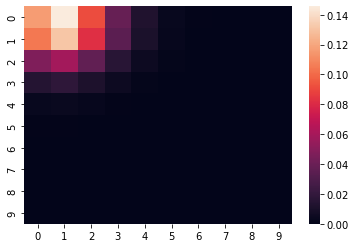

In [28]:
#MAPA DE CALOR DE LOS RESULTADOS MAS PROBABLES
sns.heatmap(partido);

In [29]:
victoria_local = np.sum(np.tril(partido, -1))
empate = np.sum(np.diag(partido))
victoria_visitante = np.sum(np.triu(partido, 1))

print('Prob implicita Victoria', local, ':', round(victoria_local*100,2), '%')
print('Prob implicita Empate:', round(empate*100, 2), '%')
print('Prob implicita Victoria', visitante, ':', round(victoria_visitante*100,2), '%')

Prob implicita Victoria Osasuna : 26.6 %
Prob implicita Empate: 28.89 %
Prob implicita Victoria Valencia : 44.51 %


## GENERALICEMOS PARA TODOS LOS PARTIDOS DE LA TEMPORADA QUE QUEREMOS PREDECIR

In [35]:
def simular_partido(stats, local, visitante):
    
    FAL, FDL, FAV, FDV = 'FAL', 'FDL', 'FAV', 'FDV'
    
    FAL = stats[stats.Equipo == local][FAL].iloc[0]
    FDL = stats[stats.Equipo == local][FDL].iloc[0]
    FAV = stats[stats.Equipo == visitante][FAV].iloc[0]
    FDV = stats[stats.Equipo == visitante][FDV].iloc[0]
        
    objetivo_esperado_local = math.exp(FAL + FDV)
    objetivo_esperado_visitante = math.exp(FAV + FDL)
    '''print('EN EL MODELO', modelo, ':\n--------------------------')
    print('Se espera que el', local, 'marque', round(objetivo_esperado_local,3), 'goles contra el', visitante)
    print('Se espera que el', visitante, 'marque', round(objetivo_esperado_visitante,3), 'goles contra el', local,'\n')'''
    team_local_poisson = [poisson.pmf(i, objetivo_esperado_local) for i in range(10)]
    team_visitante_poisson = [poisson.pmf(i, objetivo_esperado_visitante) for i in range(10)]
    partido = np.outer(team_local_poisson, team_visitante_poisson)
    tabla = pd.DataFrame(partido)
    victoria_local = np.sum(np.tril(partido, -1))
    empate = np.sum(np.diag(partido))
    victoria_visit = np.sum(np.triu(partido, 1))

    '''print('Prob implicita victoria local:', round(victoria_local*100,2), '%')
    print('Prob implicita Empate:', round(empate*100, 2), '%')
    print('Prob implicita victoria visitante:', round(victoria_visit*100,2), '%\n')'''
    
    res = max(victoria_local, empate, victoria_visit)
    if res ==  victoria_local: FTR = 'H'
    if res == empate: FTR = 'D'
    if res == victoria_visit: FTR = 'A'
    
    return FTR, tabla

In [36]:
def resultados_mas_probables(tabla):
    aux = tabla.copy()
    tops =[]
    df = pd.DataFrame(columns=['local', 'visitante', 'prob (%)'])
    prob = 0
    for _ in range(10):
        top=[0,0,prob]
        for col in range(aux.shape[1]):
            for fil in range(aux.shape[0]):
                prob = aux.iloc[fil,col]
                if prob > top[-1]: top = [fil,col,prob]
        aux.iloc[top[0], top[1]]=0
        tops.append(top)
        df = df.append({'local': top[0], 'visitante':top[1], 'prob (%)':round(top[-1]*100,2)}, ignore_index=True)
        df.local = df.local.astype('int64')
        df.visitante = df.visitante.astype('int64')
        
    return df, (df.local.iloc[0], df.visitante.iloc[0])

In [33]:
stats = stats_equipos(resultados_previos)

In [41]:
resultados_mas_probables(simular_partido(stats_equipos(resultados_previos), local, visitante)[1])[0]

,local,visitante,prob (%)
0,0,1,14.56
1,1,1,13.09
2,0,0,11.61
3,1,0,10.44
4,0,2,9.13
5,1,2,8.21
6,2,1,5.89
7,2,0,4.69
8,0,3,3.82
9,2,2,3.69
